# **Diabetic Retinopathy**

## **Importing Libraries and Utilities**

In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from matplotlib import pyplot as plt
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## **Importing the dataset**

In [ ]:
base_image_dir = '/content/gdrive/MyDrive/CVSN_project/'

retina_df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,'Train',
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
#print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

,image,level,PatientId,path,exists,eye
11631,14609_right,0,14609,/content/gdrive/MyDrive/CVSN_project/Train/146...,True,0
9309,11719_right,0,11719,/content/gdrive/MyDrive/CVSN_project/Train/117...,True,0
9305,11707_right,0,11707,/content/gdrive/MyDrive/CVSN_project/Train/117...,True,0


## **Plotting sample images for each class**

In [ ]:
def display_images(captions, images, title, rows = 1):
    
    if rows == 1:
        fig, axs = plt.subplots(1,len(images), figsize = (15,10))

        for i in range(len(images)):
            axs[i].imshow(images[i])
            axs[i].set_title(captions[i])
            axs[i].axis("off")

    else:
        fig, axs = plt.subplots(rows,int(len(images)/rows), figsize = (15,10))
        count = 0
        for i in range(rows):
            for j in range(int(len(images)/rows)):
                axs[i,j].imshow(images[count])
                axs[i,j].set_title(captions[count])
                axs[i,j].axis("off")
                count = count + 1
        
#     plt.suptitle(title)
    print('                                           '+title)
    plt.show()

                                           Images of different classes


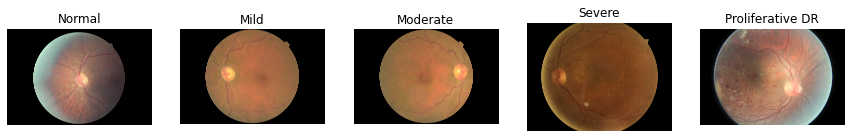

In [ ]:
normal = cv.cvtColor(cv.imread(os.path.join(base_image_dir,'Train/10_left.jpeg'), 1), cv.COLOR_BGR2RGB)
mild = cv.cvtColor(cv.imread(os.path.join(base_image_dir,'Train/15_left.jpeg'), 1), cv.COLOR_BGR2RGB)
moderate = cv.cvtColor(cv.imread(os.path.join(base_image_dir,'Train/15_right.jpeg'), 1), cv.COLOR_BGR2RGB)
severe = cv.cvtColor(cv.imread(os.path.join(base_image_dir,'Train/163_left.jpeg'), 1), cv.COLOR_BGR2RGB)
proliferative = cv.cvtColor(cv.imread(os.path.join(base_image_dir,'Train/16_left.jpeg'), 1), cv.COLOR_BGR2RGB)

image_classes = [normal, mild, moderate, severe, proliferative]
captions = ['Normal', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

display_images(captions, image_classes, 'Images of different classes')

# **Visualizing histograms for 'level' and 'eye' columns in the dataset**

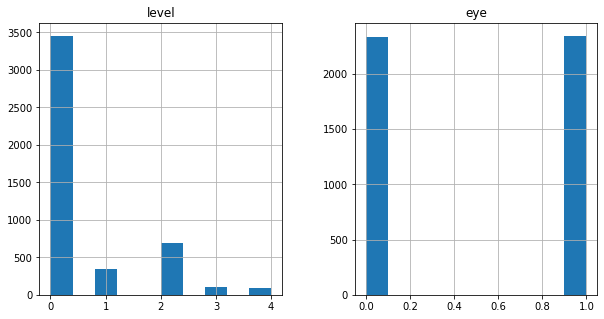

In [ ]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))
df_plot = pd.DataFrame()
df_plot['level (unbalanced)'] = retina_df[['level']]
df_plot['eye'] = retina_df[['eye']]

## **Split Data into Training and Validation**

In [ ]:
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()

train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018)
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('Train size:', raw_train_df.shape[0], 'Validation size:', valid_df.shape[0])

Train size: 3624 Validation size: 1283


## **Balance the distribution in the training set**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2387d78750>,
      dtype=object)

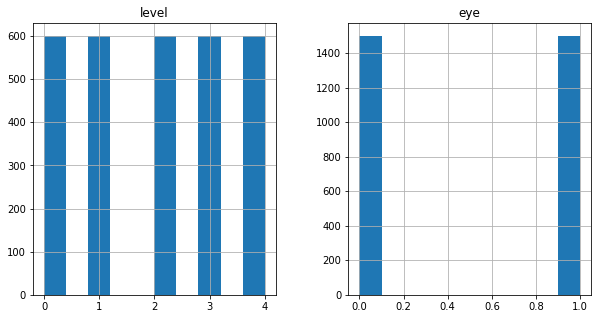

In [ ]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(300, replace = True)
                                                      ).reset_index(drop = True)
#print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [ ]:
class retinaDataset(Dataset):
    def __init__(self, imagepath, data, transform):
        self.df = data
        self.transform = transform
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        img = Image.open(img_path)
        
        if self.transform is not None:
            img = self.transform(img)
            #print(img, img.shape)
        else:
            transform = transforms.Compose([transforms.Resize((640, 640)), transforms.PILToTensor()])
            img = transform(img)
            #print(img, img.shape)
        return img, torch.tensor(self.df.iloc[index].level)


In [ ]:
def dataloader(transform, batch_size):
    train_dataset = retinaDataset(imagepath = os.path.join(base_image_dir, 'Train'), data = train_df, transform = transform)
    val_dataset = retinaDataset(imagepath = os.path.join(base_image_dir, 'Train'), data = valid_df, transform = None)

    train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
    val_dataloader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = True)

    return train_dataloader, val_dataloader

In [ ]:
def model_train(num_epochs, train_dataloader, val_dataloader, model, loss_criterion):
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 

    model.train() 
    for epoch in tqdm(range(num_epochs)):
        for data, target in train_dataloader:
            data = data.to(device=device)
            target = target.to(device=device)

            score = model(data)
            optimizer.zero_grad()

            loss = loss_criterion(score, target)
            train_losses.append(loss.item())
            loss.backward()

            optimizer.step()

        print(f"for epoch {epoch}, loss : {loss}")

      # model.eval() # prep model for evalation
      # for data, target in val_dataloader:
      #     data = data.to(device=device)
      #     target = target.to(device=device)
      #     # forward pass: compute predicted outputs by passing inputs to the model
      #     output = model(data)
      #     # calculate the loss
      #     loss = loss_criterion(output, target)
      #     # record validation loss
      #     valid_losses.append(loss.item())

      #     # print training/validation statistics 
      #     # calculate average loss over an epoch
      # scheduler.step()
      # train_loss = np.average(train_losses)
      # valid_loss = np.average(valid_losses)
      # avg_train_losses.append(train_loss)
      # avg_valid_losses.append(valid_loss)
      # epoch_len = len(str(num_epochs))

      # print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
      #             f'train_loss: {train_loss:.5f} ' +
      #             f'valid_loss: {valid_loss:.5f}')

      # print(print_msg)
    return model

In [ ]:
def check_accuracy(model, loader, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return (num_correct/num_samples).item()

## **Inception V3**

In [ ]:
model = models.inception_v3(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
    
model.dropout = torch.nn.Dropout(0.1) 
model.fc = torch.nn.Linear(in_features = 2048, out_features = 5, bias = True)
model.aux_logits = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device = device)

num_classes = 5
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

loss_criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
count_parameters(model)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| fc.weight |   10240    |
|  fc.bias  |     5      |
+-----------+------------+
Total Trainable Params: 10245


10245

### **Baseline data**

In [ ]:
transform_baseline = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
batch_size = 32
train_dataloader, val_dataloader = dataloader(transform_baseline, batch_size)

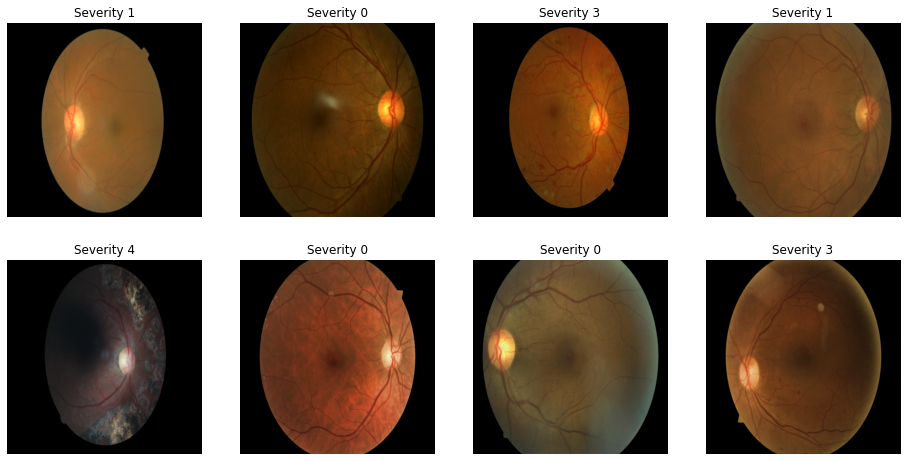

In [ ]:
mean = [0.485, 0.456, 0.406]
stdd = [0.229, 0.224, 0.225]

dataiter = iter(train_dataloader)
t_x, t_y = dataiter.next()
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_x = c_x.numpy().transpose(1, 2, 0)
    c_x = (c_x * stdd + mean).clip(0, 1)   # unnormalize
    npimg = np.array(c_x)
    c_ax.imshow(npimg)
    c_ax.set_title('Severity {}'.format(c_y))
    c_ax.axis('off')

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_inception_baseline = model_train(num_epochs, train_dataloader, val_dataloader, model, loss_criterion)
torch.save(trained_model_inception_baseline, os.path.join(base_image_dir, "Model", "inceptionv3_baseline.pt"))

 10%|█         | 1/10 [00:25<03:48, 25.38s/it]

for epoch 0, loss : 1.6574068069458008


 20%|██        | 2/10 [00:50<03:21, 25.20s/it]

for epoch 1, loss : 1.613580346107483


 30%|███       | 3/10 [01:15<02:56, 25.26s/it]

for epoch 2, loss : 1.6704130172729492


 40%|████      | 4/10 [01:41<02:31, 25.26s/it]

for epoch 3, loss : 1.614793062210083


 50%|█████     | 5/10 [02:06<02:06, 25.38s/it]

for epoch 4, loss : 1.6103800535202026


 60%|██████    | 6/10 [02:31<01:41, 25.34s/it]

for epoch 5, loss : 1.6711227893829346


 70%|███████   | 7/10 [02:57<01:15, 25.29s/it]

for epoch 6, loss : 1.6908317804336548


 80%|████████  | 8/10 [03:22<00:50, 25.23s/it]

for epoch 7, loss : 1.6585007905960083


 90%|█████████ | 9/10 [03:46<00:25, 25.07s/it]

for epoch 8, loss : 1.6717498302459717


100%|██████████| 10/10 [04:11<00:00, 25.17s/it]

for epoch 9, loss : 1.6078362464904785


In [ ]:
#-----Evaluation-----

trained_model = torch.load(os.path.join(base_image_dir, "Model", "inceptionv3.pt"))

### **Gaussian Blurring**

In [ ]:
transform_gaussian = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size = 3),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

In [ ]:
batch_size = 32
train_dataloader_gaussian, val_dataloader_gaussian = dataloader(transform_gaussian, batch_size)

### **Visualizing Original Images vs Gaussian Perturbed images**

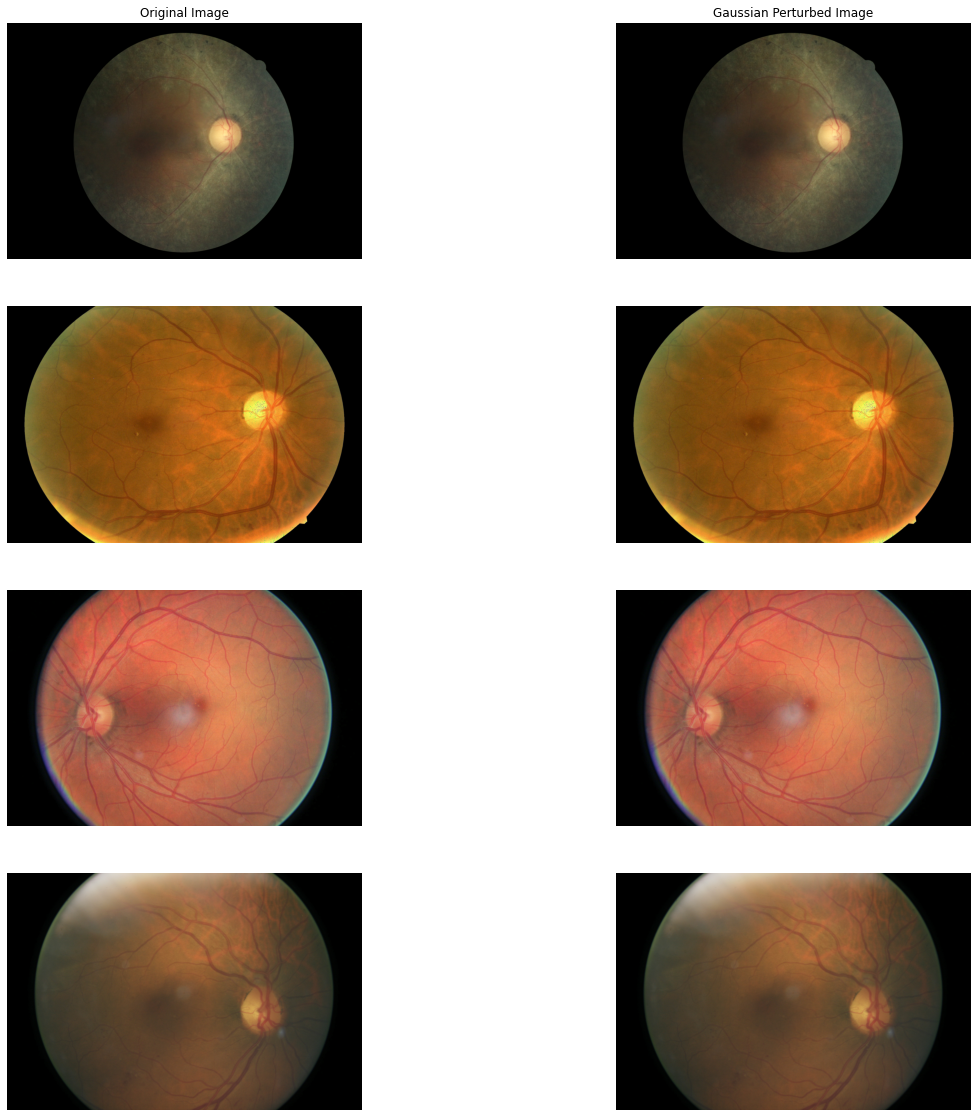

In [ ]:
df_sample = retina_df.sample(4)
fig, axs = plt.subplots(4, 2, figsize = (20, 20))
transform = transforms.Compose([transforms.Resize((2048, 3072)), transforms.PILToTensor()])
transform_gaussian_sample = transforms.Compose([transforms.Resize((2048, 3072)), transforms.GaussianBlur(kernel_size = 3, sigma = 1.5), transforms.PILToTensor()])


for i in range(0, 4):
  img_path = df_sample['path'].iloc[i]
  img = Image.open(img_path)
  img_orig = transform(img)
  
  for j in range(0, 2):

      if j == 0:
          axs[i,0].imshow(img_orig.permute(1,2,0))
          axs[i,0].axis('off')
          if i == 0:
            axs[0,0].set_title("Original Image")
            axs[0,0].axis('off')
      else:
        img_gauss = transform_gaussian_sample(img)
        axs[i,j].imshow(img_gauss.permute(1,2,0))
        axs[i,j].axis('off')
        if j == 1:
          axs[0,1].set_title("Gaussian Perturbed Image")
          axs[0,1].axis('off')

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_inception_gaussian = model_train(num_epochs, train_dataloader_gaussian, val_dataloader_gaussian, model, loss_criterion)
torch.save(trained_model_inception_gaussian, os.path.join(base_image_dir, "Model", "inceptionv3_gaussian.pt"))

 10%|█         | 1/10 [00:28<04:16, 28.55s/it]

for epoch 0, loss : 1.678179144859314


 20%|██        | 2/10 [00:56<03:44, 28.09s/it]

for epoch 1, loss : 1.5739511251449585


 30%|███       | 3/10 [01:24<03:16, 28.12s/it]

for epoch 2, loss : 1.5675318241119385


 40%|████      | 4/10 [01:52<02:48, 28.10s/it]

for epoch 3, loss : 1.5631612539291382


 50%|█████     | 5/10 [02:20<02:20, 28.20s/it]

for epoch 4, loss : 1.6135427951812744


 60%|██████    | 6/10 [02:49<01:53, 28.28s/it]

for epoch 5, loss : 1.5388529300689697


 70%|███████   | 7/10 [03:16<01:24, 28.04s/it]

for epoch 6, loss : 1.5627870559692383


 80%|████████  | 8/10 [03:43<00:55, 27.62s/it]

for epoch 7, loss : 1.525476336479187


 90%|█████████ | 9/10 [04:10<00:27, 27.42s/it]

for epoch 8, loss : 1.5871367454528809


100%|██████████| 10/10 [04:37<00:00, 27.78s/it]

for epoch 9, loss : 1.5882253646850586


### **Histogram Equalization**

In [ ]:
transform_histeq = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.transforms.RandomEqualize(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

In [ ]:
batch_size = 32
train_dataloader_histeq, val_dataloader_histeq = dataloader(transform_histeq, batch_size)

### **Visualizing Original Images vs Histogram Equalized Perturbed images**

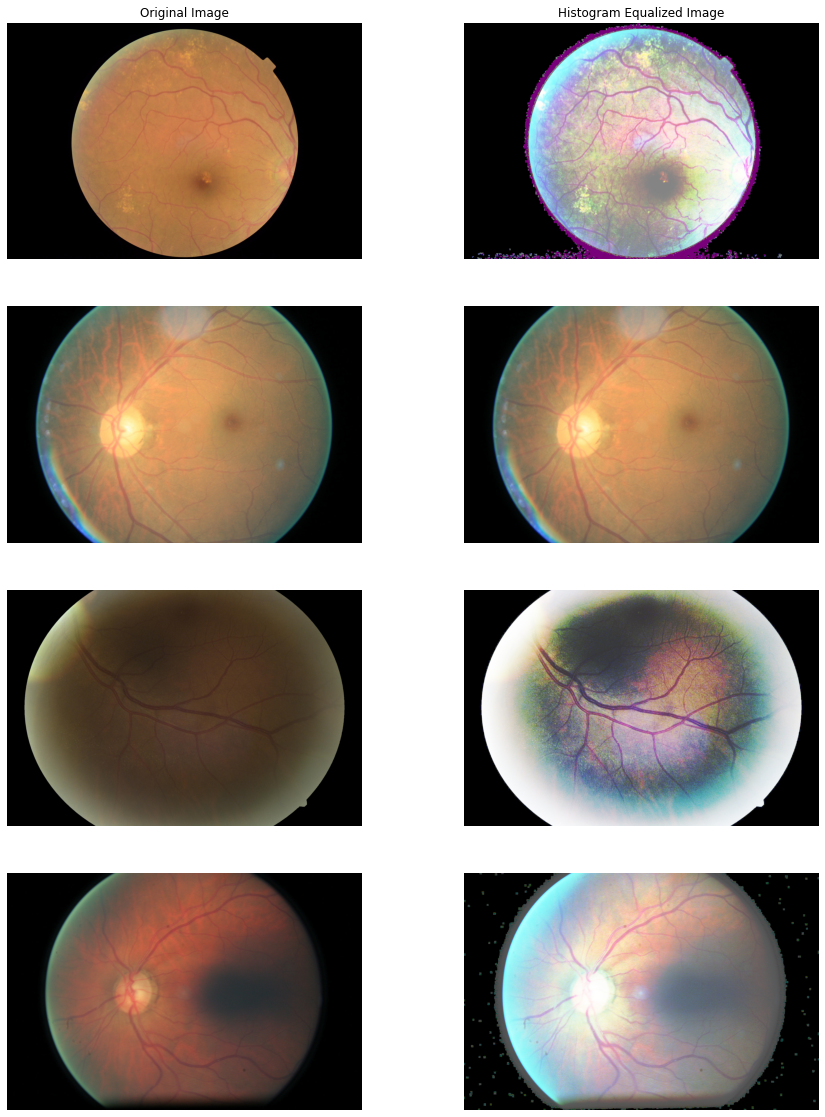

In [ ]:
import matplotlib.gridspec as gridspec

df_sample = retina_df.sample(4)
fig, axs = plt.subplots(4, 2, figsize = (15, 20))
transform = transforms.Compose([transforms.Resize((2048, 3072)), transforms.PILToTensor()])
transform_histeq_sample = transforms.Compose([transforms.Resize((2048, 3072)),  transforms.RandomEqualize(), transforms.PILToTensor()])

for i in range(0, 4):
  img_path = df_sample['path'].iloc[i]
  img = Image.open(img_path)
  img_orig = transform(img)
  
  for j in range(0, 2):

      if j == 0:
          axs[i,0].imshow(img_orig.permute(1,2,0))
          axs[i,0].axis('off')
          if i == 0:
            axs[0,0].set_title("Original Image")
            axs[0,0].axis('off')

      else:
        img_gauss = transform_histeq_sample(img)
        axs[i,j].imshow(img_gauss.permute(1,2,0))
        axs[i,j].axis('off')
        if j == 1:
          axs[0,1].set_title("Histogram Equalized Image")
          axs[0,1].axis('off')


In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_inception_histeq = model_train(num_epochs, train_dataloader_histeq, val_dataloader_histeq, model, loss_criterion)
torch.save(trained_model_inception_histeq, os.path.join(base_image_dir, "Model", "inceptionv3_histeq.pt"))

 10%|█         | 1/10 [00:24<03:42, 24.78s/it]

for epoch 0, loss : 1.5987035036087036


 20%|██        | 2/10 [00:49<03:16, 24.60s/it]

for epoch 1, loss : 1.5344151258468628


 30%|███       | 3/10 [01:13<02:49, 24.21s/it]

for epoch 2, loss : 1.5049898624420166


 40%|████      | 4/10 [01:37<02:25, 24.21s/it]

for epoch 3, loss : 1.5310263633728027


 50%|█████     | 5/10 [02:01<02:00, 24.19s/it]

for epoch 4, loss : 1.618436574935913


 60%|██████    | 6/10 [02:25<01:36, 24.20s/it]

for epoch 5, loss : 1.610998272895813


 70%|███████   | 7/10 [02:49<01:12, 24.06s/it]

for epoch 6, loss : 1.6063644886016846


 80%|████████  | 8/10 [03:13<00:47, 23.97s/it]

for epoch 7, loss : 1.5980561971664429


 90%|█████████ | 9/10 [03:37<00:23, 23.96s/it]

for epoch 8, loss : 1.69231116771698


100%|██████████| 10/10 [04:01<00:00, 24.10s/it]

for epoch 9, loss : 1.5166823863983154


### **Histogram Equalization + Gaussian Blur**

In [ ]:
transform_comb = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.transforms.RandomEqualize(),
    transforms.GaussianBlur(kernel_size = 3, sigma = 1.5),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

In [ ]:
batch_size = 32
train_dataloader_comb, val_dataloader_comb = dataloader(transform_comb, batch_size)

### **Visualizing Original Images vs Gaussian Blur + Histogram Equalized Perturbed images**

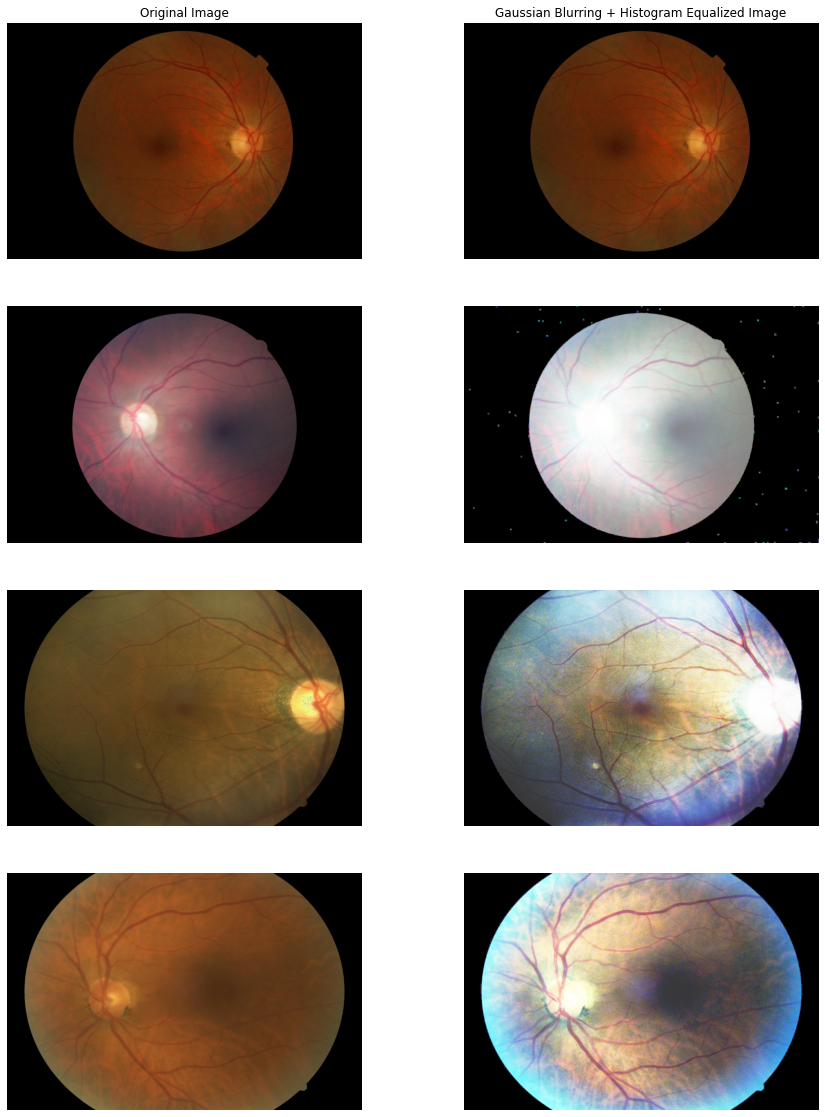

In [ ]:
df_sample = retina_df.sample(4)
fig, axs = plt.subplots(4, 2, figsize = (15, 20))
transform = transforms.Compose([transforms.Resize((2048, 3072)), transforms.PILToTensor()])
transform_comb_sample = transforms.Compose([transforms.Resize((2048, 3072)), transforms.GaussianBlur(kernel_size = 3, sigma = 1.5), transforms.RandomEqualize(), transforms.PILToTensor()])


for i in range(0, 4):
  img_path = df_sample['path'].iloc[i]
  img = Image.open(img_path)
  img_orig = transform(img)
  
  for j in range(0, 2):

      if j == 0:
          axs[i,0].imshow(img_orig.permute(1,2,0))
          axs[i,0].axis('off')
          if i == 0:
            axs[0,0].set_title("Original Image")
            axs[0,0].axis('off')
      else:
        img_comb = transform_comb_sample(img)
        axs[i,j].imshow(img_comb.permute(1,2,0))
        axs[i,j].axis('off')
        if j == 1:
          axs[0,1].set_title("Gaussian Blurring + Histogram Equalized Image")
          axs[0,1].axis('off')

In [ ]:
#-----Train and Save-----
num_epochs = 10

trained_model_inception_comb = model_train(num_epochs, train_dataloader_comb, val_dataloader_comb, model, loss_criterion)
torch.save(trained_model_inception_comb, os.path.join(base_image_dir, "Model", "inceptionv3_comb.pt"))

 10%|█         | 1/10 [00:27<04:06, 27.41s/it]

for epoch 0, loss : 1.645212173461914


 20%|██        | 2/10 [00:54<03:37, 27.14s/it]

for epoch 1, loss : 1.5597867965698242


 30%|███       | 3/10 [01:20<03:08, 26.89s/it]

for epoch 2, loss : 1.6297246217727661


 40%|████      | 4/10 [01:48<02:41, 27.00s/it]

for epoch 3, loss : 1.589568853378296


 50%|█████     | 5/10 [02:14<02:14, 26.91s/it]

for epoch 4, loss : 1.6194008588790894


 60%|██████    | 6/10 [02:41<01:47, 26.79s/it]

for epoch 5, loss : 1.512365698814392


 70%|███████   | 7/10 [03:07<01:19, 26.59s/it]

for epoch 6, loss : 1.5141589641571045


 80%|████████  | 8/10 [03:34<00:53, 26.56s/it]

for epoch 7, loss : 1.5405044555664062


 90%|█████████ | 9/10 [04:00<00:26, 26.56s/it]

for epoch 8, loss : 1.4786161184310913


100%|██████████| 10/10 [04:27<00:00, 26.70s/it]

for epoch 9, loss : 1.5613102912902832


## **VGG-16**

In [ ]:
num_classes = 5
learning_rate = 1e-4

model = models.vgg16(pretrained = True)

for param in model.parameters():
    param.requires_grad = False
    

model.classifier[6] = torch.nn.Linear(4096, 5)


model.aux_logits = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device = device)



optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

In [ ]:
count_parameters(model)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| classifier.6.weight |   20480    |
|  classifier.6.bias  |     5      |
+---------------------+------------+
Total Trainable Params: 20485


20485

### **Baseline**

In [ ]:
batch_size = 16
train_dataloader, val_dataloader = dataloader(transform_baseline, batch_size)

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_vgg_baseline = model_train(num_epochs, train_dataloader, val_dataloader, model, loss_criterion)
torch.save(trained_model_vgg_baseline, os.path.join(base_image_dir, "Model", "vgg_16_baseline.pt"))

 10%|█         | 1/10 [00:58<08:42, 58.10s/it]

for epoch 0, loss : 1.6424667835235596


 20%|██        | 2/10 [01:35<06:07, 45.93s/it]

for epoch 1, loss : 1.5320066213607788


 30%|███       | 3/10 [02:10<04:46, 40.95s/it]

for epoch 2, loss : 1.5755916833877563


 40%|████      | 4/10 [02:45<03:51, 38.56s/it]

for epoch 3, loss : 1.5011682510375977


 50%|█████     | 5/10 [03:20<03:06, 37.25s/it]

for epoch 4, loss : 1.6820225715637207


 60%|██████    | 6/10 [03:55<02:25, 36.45s/it]

for epoch 5, loss : 1.414613962173462


 70%|███████   | 7/10 [04:30<01:47, 35.91s/it]

for epoch 6, loss : 1.5383435487747192


 80%|████████  | 8/10 [05:05<01:11, 35.63s/it]

for epoch 7, loss : 1.5959067344665527


 90%|█████████ | 9/10 [05:41<00:35, 35.76s/it]

for epoch 8, loss : 1.550737977027893


100%|██████████| 10/10 [06:17<00:00, 37.70s/it]

for epoch 9, loss : 1.718691349029541


### **Gaussian Blurring**

In [ ]:
batch_size = 16
train_dataloader_gaussian, val_dataloader_gaussian = dataloader(transform_gaussian, batch_size)

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_vgg_gaussian = model_train(num_epochs, train_dataloader_gaussian, val_dataloader_gaussian, model, loss_criterion)
torch.save(trained_model_vgg_gaussian, os.path.join(base_image_dir, "Model", "vgg_16_gaussian.pt"))

 10%|█         | 1/10 [00:40<06:07, 40.85s/it]

for epoch 0, loss : 1.468668818473816


 20%|██        | 2/10 [01:18<05:13, 39.24s/it]

for epoch 1, loss : 1.3825972080230713


 30%|███       | 3/10 [01:56<04:30, 38.68s/it]

for epoch 2, loss : 1.5669782161712646


 40%|████      | 4/10 [02:35<03:51, 38.53s/it]

for epoch 3, loss : 1.41839599609375


 50%|█████     | 5/10 [03:12<03:10, 38.17s/it]

for epoch 4, loss : 1.6301770210266113


 60%|██████    | 6/10 [03:50<02:31, 37.93s/it]

for epoch 5, loss : 1.4855207204818726


 70%|███████   | 7/10 [04:29<01:55, 38.34s/it]

for epoch 6, loss : 1.4438546895980835


 80%|████████  | 8/10 [05:08<01:17, 38.58s/it]

for epoch 7, loss : 1.4392162561416626


 90%|█████████ | 9/10 [05:46<00:38, 38.33s/it]

for epoch 8, loss : 1.456730842590332


100%|██████████| 10/10 [06:24<00:00, 38.46s/it]

for epoch 9, loss : 1.5239956378936768


### **Histogram Equalization**

In [ ]:
batch_size = 16
train_dataloader_histeq, val_dataloader_histeq = dataloader(transform_histeq, batch_size)

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_vgg_histeq = model_train(num_epochs, train_dataloader_histeq, val_dataloader_histeq, model, loss_criterion)
torch.save(trained_model_vgg_histeq, os.path.join(base_image_dir, "Model", "vgg_16_histeq.pt"))

 10%|█         | 1/10 [00:36<05:27, 36.34s/it]

for epoch 0, loss : 1.3136985301971436


 20%|██        | 2/10 [01:11<04:46, 35.87s/it]

for epoch 1, loss : 1.7526755332946777


 30%|███       | 3/10 [01:47<04:09, 35.62s/it]

for epoch 2, loss : 1.5260646343231201


 40%|████      | 4/10 [02:23<03:34, 35.74s/it]

for epoch 3, loss : 1.4723474979400635


 50%|█████     | 5/10 [02:58<02:57, 35.48s/it]

for epoch 4, loss : 1.450507640838623


 60%|██████    | 6/10 [03:32<02:20, 35.16s/it]

for epoch 5, loss : 1.3103358745574951


 70%|███████   | 7/10 [04:07<01:45, 35.10s/it]

for epoch 6, loss : 1.5663702487945557


 80%|████████  | 8/10 [04:42<01:10, 35.12s/it]

for epoch 7, loss : 1.7723251581192017


 90%|█████████ | 9/10 [05:18<00:35, 35.15s/it]

for epoch 8, loss : 1.0623431205749512


100%|██████████| 10/10 [05:53<00:00, 35.33s/it]

for epoch 9, loss : 1.3503680229187012


### **Gaussian Blurring + Histogram Equalization**

In [ ]:
batch_size = 16
train_dataloader_comb, val_dataloader_comb = dataloader(transform_comb, batch_size)

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_vgg_comb = model_train(num_epochs, train_dataloader_comb, val_dataloader_comb, model, loss_criterion)
torch.save(trained_model_vgg_comb, os.path.join(base_image_dir, "Model", "vgg_16_comb.pt"))

 10%|█         | 1/10 [00:38<05:47, 38.58s/it]

for epoch 0, loss : 1.550607442855835


 20%|██        | 2/10 [01:16<05:05, 38.20s/it]

for epoch 1, loss : 1.4498374462127686


 30%|███       | 3/10 [01:54<04:26, 38.07s/it]

for epoch 2, loss : 1.209742546081543


 40%|████      | 4/10 [02:32<03:47, 37.92s/it]

for epoch 3, loss : 1.0283583402633667


 50%|█████     | 5/10 [03:10<03:09, 37.94s/it]

for epoch 4, loss : 1.7497878074645996


 60%|██████    | 6/10 [03:47<02:31, 37.88s/it]

for epoch 5, loss : 1.3724395036697388


 70%|███████   | 7/10 [04:25<01:53, 37.90s/it]

for epoch 6, loss : 1.2299814224243164


 80%|████████  | 8/10 [05:03<01:15, 37.94s/it]

for epoch 7, loss : 1.759123682975769


 90%|█████████ | 9/10 [05:44<00:38, 38.93s/it]

for epoch 8, loss : 1.676759123802185


100%|██████████| 10/10 [06:22<00:00, 38.28s/it]

for epoch 9, loss : 1.4834716320037842


### **ResNet-50**

In [ ]:
model = models.resnet50(pretrained = True)

for param in model.parameters():
    param.requires_grad = False
    
model.dropout = torch.nn.Dropout(0.1) 
model.fc = torch.nn.Linear(in_features = 2048, out_features = 5, bias = True)
model.aux_logits = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device = device)

num_classes = 5
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
count_parameters(model)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| fc.weight |   10240    |
|  fc.bias  |     5      |
+-----------+------------+
Total Trainable Params: 10245


10245

### **Baseline**

In [ ]:
batch_size = 32
train_dataloader, val_dataloader = dataloader(transform_baseline, batch_size)

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_resnet_baseline = model_train(num_epochs, train_dataloader, val_dataloader, model, loss_criterion)
torch.save(trained_model_resnet_baseline, os.path.join(base_image_dir, "Model", "resnet_50_baseline.pt"))


 10%|█         | 1/10 [00:26<03:58, 26.45s/it]

for epoch 0, loss : 1.5578213930130005


 20%|██        | 2/10 [00:51<03:24, 25.61s/it]

for epoch 1, loss : 1.5634547472000122


 30%|███       | 3/10 [01:16<02:57, 25.30s/it]

for epoch 2, loss : 1.4832690954208374


 40%|████      | 4/10 [01:41<02:30, 25.05s/it]

for epoch 3, loss : 1.6593406200408936


 50%|█████     | 5/10 [02:05<02:04, 24.87s/it]

for epoch 4, loss : 1.6092852354049683


 60%|██████    | 6/10 [02:30<01:39, 24.81s/it]

for epoch 5, loss : 1.546876072883606


 70%|███████   | 7/10 [02:54<01:14, 24.75s/it]

for epoch 6, loss : 1.5407342910766602


 80%|████████  | 8/10 [03:19<00:49, 24.75s/it]

for epoch 7, loss : 1.6869323253631592


 90%|█████████ | 9/10 [03:44<00:24, 24.89s/it]

for epoch 8, loss : 1.6309444904327393


100%|██████████| 10/10 [04:09<00:00, 24.99s/it]

for epoch 9, loss : 1.5755058526992798


### **Gaussian Blurring**

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_resnet_gaussian = model_train(num_epochs, train_dataloader_gaussian, val_dataloader_gaussian, model, loss_criterion)
torch.save(trained_model_resnet_gaussian, os.path.join(base_image_dir, "Model", "resnet_50_gaussian.pt"))

 10%|█         | 1/10 [00:29<04:24, 29.43s/it]

for epoch 0, loss : 1.720391035079956


 20%|██        | 2/10 [01:01<04:07, 30.98s/it]

for epoch 1, loss : 1.667318344116211


 30%|███       | 3/10 [01:32<03:35, 30.82s/it]

for epoch 2, loss : 1.5487382411956787


 40%|████      | 4/10 [02:04<03:07, 31.26s/it]

for epoch 3, loss : 1.484154462814331


 50%|█████     | 5/10 [02:38<02:41, 32.29s/it]

for epoch 4, loss : 1.5992707014083862


 60%|██████    | 6/10 [03:14<02:14, 33.60s/it]

for epoch 5, loss : 1.5797219276428223


 70%|███████   | 7/10 [03:51<01:44, 34.77s/it]

for epoch 6, loss : 1.6687846183776855


 80%|████████  | 8/10 [04:27<01:10, 35.20s/it]

for epoch 7, loss : 1.679777979850769


 90%|█████████ | 9/10 [05:02<00:35, 35.09s/it]

for epoch 8, loss : 1.5514256954193115


100%|██████████| 10/10 [05:39<00:00, 33.96s/it]

for epoch 9, loss : 1.5431262254714966


### **Histogram Equalization**

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_resnet_histeq = model_train(num_epochs, train_dataloader_histeq, val_dataloader_histeq, model, loss_criterion)
torch.save(trained_model_resnet_histeq, os.path.join(base_image_dir, "Model", "resnet_50_histeq.pt"))

 10%|█         | 1/10 [00:30<04:32, 30.27s/it]

for epoch 0, loss : 1.545332908630371


 20%|██        | 2/10 [00:57<03:47, 28.38s/it]

for epoch 1, loss : 1.55301833152771


 30%|███       | 3/10 [01:21<03:04, 26.41s/it]

for epoch 2, loss : 1.6140960454940796


 40%|████      | 4/10 [01:45<02:33, 25.56s/it]

for epoch 3, loss : 1.5534136295318604


 50%|█████     | 5/10 [02:09<02:04, 24.93s/it]

for epoch 4, loss : 1.488328218460083


 60%|██████    | 6/10 [02:33<01:38, 24.52s/it]

for epoch 5, loss : 1.5102490186691284


 70%|███████   | 7/10 [03:00<01:16, 25.48s/it]

for epoch 6, loss : 1.6638877391815186


 80%|████████  | 8/10 [03:31<00:54, 27.30s/it]

for epoch 7, loss : 1.524233102798462


 90%|█████████ | 9/10 [04:04<00:28, 28.83s/it]

for epoch 8, loss : 1.461775779724121


100%|██████████| 10/10 [04:30<00:00, 27.10s/it]

for epoch 9, loss : 1.6287578344345093


### **Gaussian Blurring + Histogram Equalization**

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_resnet_comb = model_train(num_epochs, train_dataloader_comb, val_dataloader_comb, model, loss_criterion)
torch.save(trained_model_resnet_comb, os.path.join(base_image_dir, "Model", "resnet_50_comb.pt"))

 10%|█         | 1/10 [00:28<04:15, 28.37s/it]

for epoch 0, loss : 1.6624315977096558


 20%|██        | 2/10 [01:03<04:18, 32.27s/it]

for epoch 1, loss : 1.491589069366455


 30%|███       | 3/10 [01:37<03:53, 33.33s/it]

for epoch 2, loss : 1.6020636558532715


 40%|████      | 4/10 [02:09<03:14, 32.49s/it]

for epoch 3, loss : 1.444024682044983


 50%|█████     | 5/10 [02:48<02:54, 34.97s/it]

for epoch 4, loss : 1.5193583965301514


 60%|██████    | 6/10 [03:15<02:08, 32.22s/it]

for epoch 5, loss : 1.5707182884216309


 70%|███████   | 7/10 [03:47<01:36, 32.07s/it]

for epoch 6, loss : 1.4807610511779785


 80%|████████  | 8/10 [04:14<01:00, 30.46s/it]

for epoch 7, loss : 1.4149377346038818


 90%|█████████ | 9/10 [04:41<00:29, 29.38s/it]

for epoch 8, loss : 1.594385027885437


100%|██████████| 10/10 [05:07<00:00, 30.80s/it]

for epoch 9, loss : 1.6038440465927124


## **DenseNet121**

In [ ]:
model = models.densenet121(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Linear(1024, 5)

#model.dropout = torch.nn.Dropout(0.1) 
#model.fc = torch.nn.Linear(in_features = 1024, out_features = 5, bias = True)
model.aux_logits = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device = device)

num_classes = 5
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
count_parameters(model)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| classifier.weight |    5120    |
|  classifier.bias  |     5      |
+-------------------+------------+
Total Trainable Params: 5125


5125

### **Baseline**

In [ ]:
batch_size = 32
train_dataloader, val_dataloader = dataloader(transform_baseline, batch_size)

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_dense_baseline = model_train(num_epochs, train_dataloader, val_dataloader, model, loss_criterion)
torch.save(trained_model_dense_baseline, os.path.join(base_image_dir, "Model", "dense_baseline.pt"))


 10%|█         | 1/10 [00:24<03:41, 24.59s/it]

for epoch 0, loss : 1.7351582050323486


 20%|██        | 2/10 [00:48<03:15, 24.46s/it]

for epoch 1, loss : 1.5181955099105835


 30%|███       | 3/10 [01:13<02:52, 24.64s/it]

for epoch 2, loss : 1.6151787042617798


 40%|████      | 4/10 [01:38<02:27, 24.57s/it]

for epoch 3, loss : 1.6337357759475708


 50%|█████     | 5/10 [02:02<02:02, 24.56s/it]

for epoch 4, loss : 1.6623928546905518


 60%|██████    | 6/10 [02:32<01:44, 26.25s/it]

for epoch 5, loss : 1.5967649221420288


 70%|███████   | 7/10 [02:57<01:17, 25.80s/it]

for epoch 6, loss : 1.5338501930236816


 80%|████████  | 8/10 [03:22<00:50, 25.48s/it]

for epoch 7, loss : 1.6690582036972046


 90%|█████████ | 9/10 [03:47<00:25, 25.35s/it]

for epoch 8, loss : 1.574885606765747


100%|██████████| 10/10 [04:12<00:00, 25.22s/it]

for epoch 9, loss : 1.6371591091156006


### **Gaussian Blurring**

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_dense_gaussian = model_train(num_epochs, train_dataloader_gaussian, val_dataloader_gaussian, model, loss_criterion)
torch.save(trained_model_dense_gaussian, os.path.join(base_image_dir, "Model", "dense_gaussian.pt"))


 10%|█         | 1/10 [00:28<04:16, 28.51s/it]

for epoch 0, loss : 1.6871415376663208


 20%|██        | 2/10 [00:56<03:45, 28.17s/it]

for epoch 1, loss : 1.5697053670883179


 30%|███       | 3/10 [01:24<03:17, 28.25s/it]

for epoch 2, loss : 1.6227338314056396


 40%|████      | 4/10 [01:52<02:49, 28.21s/it]

for epoch 3, loss : 1.5856969356536865


 50%|█████     | 5/10 [02:20<02:20, 28.12s/it]

for epoch 4, loss : 1.6846613883972168


 60%|██████    | 6/10 [02:49<01:52, 28.24s/it]

for epoch 5, loss : 1.5999853610992432


 70%|███████   | 7/10 [03:18<01:25, 28.45s/it]

for epoch 6, loss : 1.502368688583374


 80%|████████  | 8/10 [03:46<00:56, 28.48s/it]

for epoch 7, loss : 1.5185935497283936


 90%|█████████ | 9/10 [04:14<00:28, 28.35s/it]

for epoch 8, loss : 1.542873501777649


100%|██████████| 10/10 [04:42<00:00, 28.28s/it]

for epoch 9, loss : 1.588011622428894


### **Histogram Equalization**

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_dense_histeq = model_train(num_epochs, train_dataloader_histeq, val_dataloader_histeq, model, loss_criterion)
torch.save(trained_model_dense_histeq, os.path.join(base_image_dir, "Model", "dense_histeq.pt"))

 10%|█         | 1/10 [00:24<03:42, 24.71s/it]

for epoch 0, loss : 1.584376335144043


 20%|██        | 2/10 [00:49<03:15, 24.50s/it]

for epoch 1, loss : 1.5757420063018799


 30%|███       | 3/10 [01:13<02:51, 24.46s/it]

for epoch 2, loss : 1.6284432411193848


 40%|████      | 4/10 [01:38<02:27, 24.64s/it]

for epoch 3, loss : 1.6791245937347412


 50%|█████     | 5/10 [02:03<02:03, 24.72s/it]

for epoch 4, loss : 1.423083782196045


 60%|██████    | 6/10 [02:28<01:39, 24.81s/it]

for epoch 5, loss : 1.6904041767120361


 70%|███████   | 7/10 [02:53<01:15, 25.06s/it]

for epoch 6, loss : 1.4249361753463745


 80%|████████  | 8/10 [03:19<00:50, 25.25s/it]

for epoch 7, loss : 1.630027174949646


 90%|█████████ | 9/10 [03:44<00:25, 25.28s/it]

for epoch 8, loss : 1.4236221313476562


100%|██████████| 10/10 [04:09<00:00, 24.95s/it]

for epoch 9, loss : 1.7144160270690918


### **Gaussian Blurring + Histogram Equalization**

In [ ]:
#-----Train and Save-----
num_epochs = 10
trained_model_dense_comb = model_train(num_epochs, train_dataloader_comb, val_dataloader_comb, model, loss_criterion)
torch.save(trained_model_dense_comb, os.path.join(base_image_dir, "Model", "dense_comb.pt"))

 10%|█         | 1/10 [00:28<04:19, 28.83s/it]

for epoch 0, loss : 1.650748610496521


 20%|██        | 2/10 [00:57<03:50, 28.86s/it]

for epoch 1, loss : 1.56712806224823


 30%|███       | 3/10 [01:26<03:22, 28.90s/it]

for epoch 2, loss : 1.591982126235962


 40%|████      | 4/10 [01:55<02:53, 28.84s/it]

for epoch 3, loss : 1.6204651594161987


 50%|█████     | 5/10 [02:23<02:23, 28.73s/it]

for epoch 4, loss : 1.5551810264587402


 60%|██████    | 6/10 [02:53<01:55, 28.90s/it]

for epoch 5, loss : 1.5837947130203247


 70%|███████   | 7/10 [03:22<01:27, 29.02s/it]

for epoch 6, loss : 1.662684679031372


 80%|████████  | 8/10 [03:51<00:58, 29.09s/it]

for epoch 7, loss : 1.5447494983673096


 90%|█████████ | 9/10 [04:21<00:29, 29.18s/it]

for epoch 8, loss : 1.5541887283325195


100%|██████████| 10/10 [04:50<00:00, 29.03s/it]

for epoch 9, loss : 1.5180277824401855


## **Ensemble Model**

### **Baseline**

In [ ]:
trained_model_inception_baseline = torch.load(os.path.join(base_image_dir, "Model", "inceptionv3_baseline.pt"))
trained_model_vgg_baseline = torch.load(os.path.join(base_image_dir, "Model", "vgg_16_baseline.pt"))
trained_model_resnet_baseline = torch.load(os.path.join(base_image_dir, "Model", "resnet_50_baseline.pt"))
trained_model_dense_baseline = torch.load(os.path.join(base_image_dir, "Model", "dense_baseline.pt"))

In [ ]:
valid_df['path'].values

array(['/content/gdrive/MyDrive/CVSN_project/Train/15_left.jpeg',
       '/content/gdrive/MyDrive/CVSN_project/Train/15_right.jpeg',
       '/content/gdrive/MyDrive/CVSN_project/Train/17_left.jpeg', ...,
       '/content/gdrive/MyDrive/CVSN_project/Train/16581_right.jpeg',
       '/content/gdrive/MyDrive/CVSN_project/Train/16585_left.jpeg',
       '/content/gdrive/MyDrive/CVSN_project/Train/16585_right.jpeg'],
      dtype=object)

In [ ]:
image = Image.open("/content/gdrive/MyDrive/CVSN_project/Train/15_left.jpeg")

img = transform_baseline(image).unsqueeze(0)

score_inception = trained_model_inception_baseline(img.cuda())
_, predictions_inception = score_inception.max(1)

score_vgg = trained_model_vgg_baseline(img.cuda())
_, predictions_vgg = score_vgg.max(1)

score_resnet= trained_model_resnet_baseline(img.cuda())
_, predictions_resnet = score_resnet.max(1)

score_dense = trained_model_dense_baseline(img.cuda())
_, predictions_dense = score_dense.max(1)

print("predicted: ", predictions_inception, predictions_vgg, predictions_resnet, predictions_dense)

predicted:  tensor([3], device='cuda:0') tensor([2], device='cuda:0') tensor([4], device='cuda:0') tensor([4], device='cuda:0')
